In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pypalettes import load_cmap

mpl_params = {
    "text.usetex": True,
    "text.latex.preamble": "\n".join(
        [
            r"\usepackage{siunitx}",
            r"\sisetup{detect-all}",
            r"\usepackage{amsmath}",
            r'\usepackage[utf8]{inputenc}',
            r'\usepackage[russian]{babel}'
        ]
    ),
    "axes.spines.right": False,
    "axes.spines.top": False,
    "font.family": "Times New Roman",
    "font.size": 12,
    "legend.frameon": False,
}

plt.rcParams.update(mpl_params)
mm2inch = 1e-1 / 2.54

## Коэффициенты распыления

Коэффициенты распыления рассчитаны на основе: 
1. Behrisch R., Eckstein W. (ed.). Sputtering by particle bombardment: experiments and computer calculations from threshold to MeV energies. – Springer Science & Business Media, 2007. – Т. 110.
2. INTERNATIONAL ATOMIC ENERGY AGENCY, Atomic and Plasma–Material Interaction Data for Fusion, Atomic and Plasma–Material Interaction Data for Fusion Vol. 7/B, IAEA, Vienna (2001)
3. J. Roth / Journal of Nuclear Materials 266-269 (1999) 51-57
4. J. Roth et al 2004 Nucl. Fusion 44 L21

/tmp/ipykernel_2122/4142637024.py:12: RuntimeWarning: invalid value encountered in power
  Y = q * sn * (E / E_th - 1) ** mu / (l + (E / E_th - 1) ** mu)


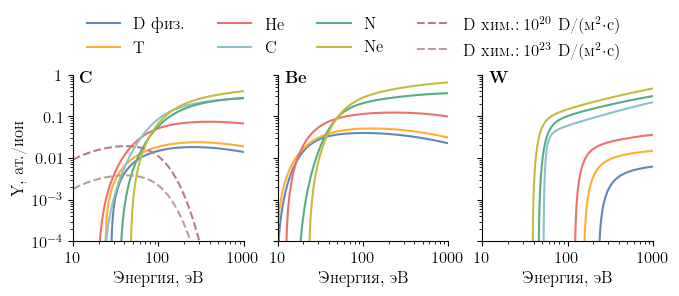

In [166]:
cmap = load_cmap("Superfishel_Stone", cmap_type="discrete")


k_B = 1 / 11600

def Y(E, l, q, mu, E_th, eps_L):
    
    eps =  E / eps_L

    sn = 0.5 * np.log(1 + 1.2288 * eps) / (eps + 0.1728 * np.sqrt(eps) + 0.008 * eps ** 0.1504)

    Y = q * sn * (E / E_th - 1) ** mu / (l + (E / E_th - 1) ** mu)

    return Y

def Y_chem(E, Flux, T):
    E_therm = 1.7
    E_rel = 1.8
    Q = 0.12
    E_dam = 15
    E_des = 2
    E_TF = 479
    D = 83

    eps = E / E_TF

    C = 1 / (1 + 3e7 * np.exp(-1.4/k_B/T))

    c_sp3 = C * (2e-32 * Flux + np.exp(-E_therm / k_B / T)) / (2e-32 * Flux + (1 + 2e29 / Flux * np.exp(-E_rel / k_B / T)) * np.exp(-E_therm / k_B / T))

    Y_therm = c_sp3 * 0.033 * np.exp(-E_therm / k_B / T) / (2e-32 * Flux + np.exp(-E_therm / k_B / T))

    sn = 0.5 * np.log(1 + 1.2288 * eps) / (eps + 0.1728 * np.sqrt(eps) + 0.008 * eps ** 0.1504)

    Y_dam = Q * sn * (1 - (E_dam / E)**(2/3)) * (1 - E_dam / E) ** 2

    Y_des = Q * sn * (1 - (E_des / E)**(2/3)) * (1 - E_des / E) ** 2

    Y_surf = c_sp3 * Y_des / (1 + np.exp((E-65) / 40))

    return (Y_therm * (1 + D * Y_dam) + Y_surf) / (1 + (Flux / 6e21) ** 0.54)

E = np.geomspace(1, 1e3, 100000)

Be_params ={
    "D": [1.7575, 0.1044, 1.9906, 9.5059, 2.82110e+2],
    "T": [2.0794, 0.1379, 1.5660, 9.4345, 3.07966e+2],
    "He": [1.4745, 0.3193, 1.6989, 12.3288, 7.19545e+2],
    "N": [5.2833, 0.9334, 2.5368, 16.5425, 5.46566e+3],
    "Ne": [2.5474, 1.8309, 1.9400, 22.7750, 1.06588e+4]   
}

C_params ={
    "D физ.": [1.2848, 0.0539, 1.1977, 27.770, 4.46507e+2],
    "T": [1.9050, 0.0718, 1.1512, 23.617, 4.78673e+2],
    "He": [4.5910, 0.1951, 1.7852, 19.124, 1.08716e+3],
    "C": [13.9666, 0.7015, 2.0947, 21.4457, 5.68684e+3],
    "N": [5.4288, 0.7481, 1.7701, 34.9372, 7.37899e+3],
    "Ne": [2.5015, 1.1912, 1.6551, 46.6904, 1.39308e+4]   
}

W_params = {
    "D": [0.3583, 0.0183, 1.4410, 228.84, 9.92326e3],
    "T": [0.2870, 0.0419, 1.5802, 153.8842, 9.97718e3],
    "He": [0.1692, 0.1151, 1.71221, 120.56, 2.03728e4],
    "C": [1.8984e-2, 1.9221, 1.8857, 5.1992e1, 1/2.8775e-6],
    "N": [0.0921, 1.4389, 2.0225, 45.3362, 7.90505e4],
    "Ne": [0.0828, 2.5520, 1.9534, 38.6389, 1.19107e5]
}

fig, axs = plt.subplots(1,3, figsize=(190*mm2inch, 55*mm2inch), sharey=True)

for i, (key, values) in enumerate(Be_params.items()):
    if i > 2:
        k = i + 1
    else:
        k = i
    axs[1].plot(E, Y(E, *values), label=key, color=cmap(k), lw = 1.5)

for i, (key, values) in enumerate(C_params.items()):
    axs[0].plot(E, Y(E, *values), label=key, color=cmap(i), lw = 1.5)

axs[0].plot(E, Y_chem(E, 1e20, 300), lw = 1.5, ls='dashed', label=r"D хим.: $10^{20}$ D/(м$^{2}\cdot$с$)$", color=cmap(i+1))
axs[0].plot(E, Y_chem(E, 1e23, 300), lw = 1.5, ls='dashed', label=r"D хим.: $10^{23}$ D/(м$^{2}\cdot$с$)$", color=cmap(i+2))

for i, (key, values) in enumerate(W_params.items()):
    axs[2].plot(E, Y(E, *values), label=key, color=cmap(i), lw = 1.5)

titles = [r"$\textbf{C}$", r"$\textbf{Be}$", r"$\textbf{W}$"]

for i, axis in enumerate(axs):
    axis.text(12, 0.8, titles[i], ha="left", va="center")
    axis.set_xscale('log')
    axis.set_yscale('log')
    axis.set_ylim(1e-4, 1)
    axis.set_xlim(10,1e3)
    axis.set_xlabel("Энергия, эВ")
    axis.set_xticks([10,100,1000])
    axis.set_xticklabels(["10", "100", "1000"])

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0, 1.02, 1, 0.2))

axs[0].set_ylabel("Y, ат./ион")
axs[0].set_yticks([1e-4, 1e-3, 1e-2, 1e-1, 1])
axs[0].set_yticklabels([r"$\num{e-4}$", r"$\num{e-3}$", "0.01", "0.1", "1"])

plt.savefig('../../Thesis/images/sputerring_yields.pdf', bbox_inches="tight", pad_inches=0.02)
plt.show()

## Диаграмма потенциалньой энергии

In [100]:
import numpy as np
import matplotx
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from pyenergydiagrams import State, Diagram


class CustomDiagram(Diagram):
    def make_x_y_raw(self):
        x_raw, y_raw = [], []
        eps = 0.001
        for i, state in enumerate(self.states):
            x_raw += [i + j * eps for j in range(state.copies)]
            y_raw += [state.E] * state.copies
        return x_raw, y_raw

    def make_curve(self, nb_samples=2000, kind="quadratic"):
        f = interp1d(self.x_raw, self.energies, kind=kind)

        x_new = np.linspace(min(self.x_raw), max(self.x_raw), nb_samples)
        y_smooth = f(x_new)
        return x_new, y_smooth

    def add_arrow(
        self,
        state1,
        state2,
        text="",
        loc_text="middle-right",
        kwargs_arrow={},
        kwargs_text={},
    ):
        # arrow
        plt.annotate(
            text="",
            xy=(self.states.index(state1), state1.E),
            xytext=(self.states.index(state1), state2.E),
            arrowprops=dict(
                arrowstyle="<|-|>", color="black", lw=0.5, shrinkA=0, shrinkB=0
            ),
            **kwargs_arrow
        )

        if loc_text == "middle-right":
            xytext = (self.states.index(state1) + 0.1, (state1.E + state2.E) / 2)
            ha = "left"
        elif loc_text == "middle-left":
            xytext = (self.states.index(state1) - 0.1, (state1.E + state2.E) / 2)
            ha = "right"
        elif loc_text == "top":
            xytext = (
                self.states.index(state1),
                (state1.E + state2.E) / 2 + abs(state1.E - state2.E) / 2 + 0.3,
            )
            ha = "center"
        elif loc_text == "bottom":
            xytext = (
                self.states.index(state1),
                (state1.E + state2.E) / 2 - abs(state1.E - state2.E) / 2 - 0.2,
            )
            ha = "center"

        # text
        plt.annotate(
            text=text, xy=xytext, ha=ha, va="center", fontsize=12, **kwargs_text
        )

    def add_line(self, state, dx_left=0, dx_right=0, linestyles="solid", **kwargs):
        index = self.states.index(state)
        plt.hlines(
            y=state.E,
            xmin=index - dx_left,
            xmax=index + dx_right,
            linestyles=linestyles,
            **kwargs
        )


def add_transition(x_start, x_end, y, label, direction):
    mult = 1 if direction == "right" else -1
    arrowstyle = "-|>"

    plt.scatter(x=x_start, y=y, marker="o", s=15, color="black")
    plt.annotate(
        text="",
        xy=(x_end + mult * 0.1, y),
        xytext=(x_start, y),
        arrowprops=dict(
            arrowstyle=arrowstyle, color="black", lw=0.5, shrinkA=0, shrinkB=0
        ),
    )
    plt.annotate(
        text=label,
        xy=(min(x_start, x_end) - 0.45, y),
        va="center",
        ha="center",
        color="black",
        fontsize=12,
    )

font = {"color": "black", "fontsize": 12}
text_kwargs = {"ha": "center", "va": "center"}

arrowline_kwargs = {"ls": "solid", "color": "black", "lw": 0.5}
greyline_kwargs = {
    "ls": "solid",
    "color": "lightgrey",
    "lw": 0.75,
    "zorder": 0,
}

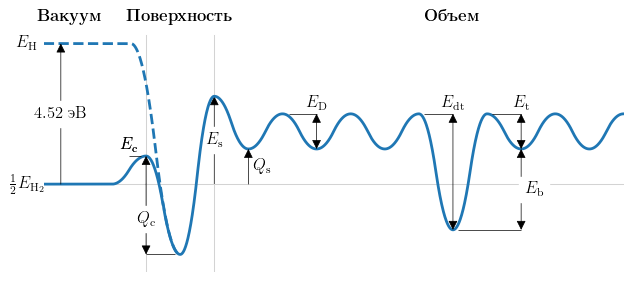

In [226]:
plt.figure(figsize=(190 * mm2inch, 80 * mm2inch))

energies = [-0.5, -0.5, -0.5, 0.3, -2.5, 2.0, *[0.5, 1.5] * 3, -1.8, 1.5, *[0.5, 1.5]*2]

energies_atom = [3.5, 3.5, 3.5, 3.5, -2.5]

main_states = [State(E=E) for E in energies]

sub_states = [State(E=E) for E in energies_atom]

adsorption_site = main_states[4]
first_solution_site = main_states[6]

main_diagram = CustomDiagram(main_states)
sub_diagram = CustomDiagram(sub_states)
sub_diagram.x_raw = [0.0, 0.001, 0.002, 1.0, 1.001, 1.002, 2.0, 2.001, 2.002, 2.551, 2.552, 2.553, 4.001, 4.002, 4.003]

sub_diagram.x, sub_diagram.y = sub_diagram.make_curve(kind="quadratic")

with plt.style.context(matplotx.styles.dufte):

    plt.plot(sub_diagram.x, sub_diagram.y, color="tab:blue", lw=2, ls="dashed")
    plt.plot(main_diagram.x, main_diagram.y, color="tab:blue", lw=2)

    main_diagram.add_line(main_states[7], dx_left=-0.2, dx_right=1, **arrowline_kwargs)
    main_diagram.add_arrow(
        main_states[8],
        main_states[9],
        "$E_\mathrm{D}$",
        loc_text="top",
        kwargs_text={"color": "black"},
    )

    main_diagram.add_line(
        adsorption_site, dx_left=1, dx_right=-0.15, **arrowline_kwargs
    )

    main_diagram.add_arrow(
        main_states[12],
        main_states[13],
        "$E_\mathrm{dt}$",
        loc_text="top",
        kwargs_text={"color": "black"},
    )

    main_diagram.add_line(
        main_states[11], dx_left=-0.15, dx_right=1, **arrowline_kwargs
    )

    main_diagram.add_arrow(
        main_states[14],
        main_states[12],
        "$E_\mathrm{b}$",
        loc_text="middle-right",
        kwargs_text={"color": "black", "backgroundcolor": "white"},
    )

    main_diagram.add_line(
        main_states[12], dx_left=-0.15, dx_right=2, **arrowline_kwargs
    )

    main_diagram.add_arrow(
        main_states[14],
        main_states[15],
        "$E_\mathrm{t}$",
        loc_text="top",
        kwargs_text={"color": "black"},
    )

    main_diagram.add_line(
        main_states[13], dx_left=-0.15, dx_right=1, **arrowline_kwargs
    )

    plt.text(
        x=main_states.index(adsorption_site) - 1.5,
        y=(main_states[2].E + main_states[3].E) / 2
        + abs(main_states[2].E - main_states[3].E) / 2
        + 0.3,
        s=r"$E_\mathrm{c}$",
        va="center",
        ha="center",
        color="black",
        fontsize=12,
    )
    plt.plot(
        [min(main_diagram.x), max(main_diagram.x)], [-0.5, -0.5], **greyline_kwargs
    )

    plt.plot(
        [
            main_states.index(adsorption_site) - 1,
            main_states.index(adsorption_site) - 1,
        ],
        [-5, -0.5],
        **greyline_kwargs
    )

    plt.plot(
        [
            main_states.index(adsorption_site) - 1,
            main_states.index(adsorption_site) - 1,
        ],
        [main_states[2].E, 3.75],
        **greyline_kwargs
    )

    plt.plot(
        [
            main_states.index(first_solution_site) - 1,
            main_states.index(first_solution_site) - 1,
        ],
        [-5, -0.5],
        **greyline_kwargs
    )

    plt.plot(
        [
            main_states.index(first_solution_site) - 1,
            main_states.index(first_solution_site) - 1,
        ],
        [energies[main_states.index(first_solution_site) - 1], 3.75],
        **greyline_kwargs
    )

    plt.annotate(
        text="",
        xy=(main_states.index(adsorption_site) - 1, main_states[0].E),
        xytext=(main_states.index(adsorption_site) - 1, main_states[2].E),
        arrowprops=dict(arrowstyle="<|-", color="black", lw=0.5, shrinkA=0, shrinkB=0),
    )

    plt.text(
        x=main_states.index(adsorption_site) - 1.5,
        y=(main_states[2].E + main_states[3].E) / 2
        + abs(main_states[2].E - main_states[3].E) / 2
        + 0.3,
        s=r"$E_\mathrm{c}$",
        va="center",
        ha="center",
        color="black",
        fontsize=12,
    )

    plt.annotate(
        text="",
        xy=(main_states.index(adsorption_site)-1, -0.5),
        xytext=(main_states.index(adsorption_site)-1, adsorption_site.E),
        arrowprops=dict(arrowstyle="<|-", color="black", lw=0.5, shrinkA=0, shrinkB=0),
    )

    plt.text(
        x=main_states.index(adsorption_site)-1,
        y=(adsorption_site.E - 0.5) / 2,
        s=r"$Q_\mathrm{c}$",
        va="center",
        ha="center",
        color="black",
        fontsize=12,
        backgroundcolor="white"
    )

    plt.hlines(
        y=(main_states[2].E + main_states[3].E) / 2
        + abs(main_states[2].E - main_states[3].E) / 2,
        xmin=main_states.index(adsorption_site) - 1.5,
        xmax=main_states.index(adsorption_site) - 1 - 0.15,
        **arrowline_kwargs
    )

    plt.annotate(
        text="",
        xy=(0.5, -0.5),
        xytext=(0.5, 3.5),
        arrowprops=dict(arrowstyle="<|-", color="black", lw=0.5, shrinkA=0, shrinkB=0),
    )

    plt.annotate(
        text="",
        xy=(main_states.index(first_solution_site)-1, -0.5),
        xytext=(main_states.index(first_solution_site)-1, main_states[main_states.index(first_solution_site)-1].E),
        arrowprops=dict(arrowstyle="<|-", color="black", lw=0.5, shrinkA=0, shrinkB=0),
        zorder=-2
    )

    plt.text(
        x=main_states.index(first_solution_site)-1,
        y=(main_states[main_states.index(first_solution_site)-1].E-0.5) / 2,
        s=r"$E_\mathrm{s}$",
        va="center",
        ha="center",
        color="black",
        fontsize=12,
        backgroundcolor = "white",
        zorder=-1
    )

    plt.text(
        x=main_states.index(first_solution_site)+0.4,
        y=(first_solution_site.E-0.5) / 2,
        s=r"$Q_\mathrm{s}$",
        va="center",
        ha="center",
        color="black",
        fontsize=12,
    )

    plt.annotate(
        text="",
        xy=(main_states.index(first_solution_site), -0.5),
        xytext=(main_states.index(first_solution_site), first_solution_site.E),
        arrowprops=dict(arrowstyle="<|-", color="black", lw=0.5, shrinkA=0, shrinkB=0),
    )

    plt.annotate(
        text="",
        xy=(main_states.index(adsorption_site)-1, -0.5),
        xytext=(main_states.index(adsorption_site)-1, main_states[main_states.index(adsorption_site)-1].E),
        arrowprops=dict(arrowstyle="<|-", color="black", lw=0.5, shrinkA=0, shrinkB=0),
    )

    plt.text(
        x=0.5,
        y=3 / 2,
        s=r"4.52 эВ",
        va="center",
        ha="center",
        color="black",
        fontsize=12,
        backgroundcolor="white",
    )

    plt.text(x=0.75, y=4.25, s=r"\textbf{Вакуум}", fontdict=font, **text_kwargs)

    plt.text(x=4, y=4.25, s=r"\textbf{Поверхность}", fontdict=font, **text_kwargs)

    plt.text(x=12, y=4.25, s=r"\textbf{Объем}", fontdict=font, **text_kwargs)

    plt.text(x=-0.5, y=-0.5, s=r"$\frac{1}{2}E_{\mathrm{H}_2}$", fontdict=font, **text_kwargs)

    plt.text(x=-0.5, y=3.5, s=r"$E_{\mathrm{H}}$", fontdict=font, **text_kwargs)

    plt.ylim(-3, 3.9)
    plt.xticks([])
    plt.yticks([])

    plt.savefig("../../Thesis/images/potential_diagram_all.pdf", bbox_inches="tight", pad_inches=0.02)
    plt.show()